# Identifying Similar Questions

## Random Forest

Link to Data: https://www.kaggle.com/mysarahmadbhat/quora-questions-duplicacy

## Notebook Results

| Model                                           | True Positive | True Negative  | False Positive | False Negative | Accuracy | Precision | Recall | F1-Score | AOC AUC | Log Loss |
|-------------------------------------------------|---------------|----------------|----------------|----------------|----------|-----------|--------|----------|---------|----------|
| Random Forest (Original Embeddings, Unbalanced) | **1777**      | 6042           | **1850**      | 331            |**0.7819**  | 0.8430    |**0.4899**|**0.6197**| 0.8500  | 0.4959   |
| Random Forest (Original Embeddings, Balanced)   | 1712          | **6100**       | 1915          | **273**        | 0.7812   |**0.8625** | 0.4720 | 0.6101   |**0.8546**|**0.4907**|
| Random Forest (Cleaned Embeddings, Unbalanced)  | 1545          | 5987           | 2082          | 386            | 0.7532    | 0.8001    | 0.4260 | 0.5560   | 0.8109  | 0.5295   |
| Random Forest (Cleaned Embeddings, Balanced)    | 1480          | 6048           | 2147          | 325            | 0.7528    | 0.8199    | 0.4081 | 0.5449   | 0.8193  | 0.5236   |

**Imports**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, log_loss
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

**Import the datasets**

In [2]:
df = pd.read_csv('../quora_preprocessed_embeddings.csv')
df_cleaned = pd.read_csv('../quora_cleaned_preprocessed_embeddings.csv')

In [3]:
df['is_duplicate'] = df['is_duplicate'].astype(int) 
df_cleaned['is_duplicate'] = df_cleaned['is_duplicate'].astype(int) 

**Splitting the data into training and testing sets**

In [7]:
num_samples = df.shape[0]
training_samples = int(num_samples * 0.9)
testing_samples = int(num_samples * 0.1)
print('{} number of samples'.format(num_samples))
print('{} training samples'.format(training_samples))
print('{} testing samples'.format(num_samples - training_samples))

100000 number of samples
90000 training samples
10000 testing samples


I am shuffling and splitting the dataset manually in order to preserve the questions in the same index as the embeddings. This will allow me to look at which questions I got wrong by comparing indexes of the incorrect predictions and finding the questions themselves.

I will also be excluding the word counts because of the large amount of features already in the dataset. Inclusing the word counts will not have a significant effect.

In [8]:
### Shuffle both datasets
df_suffled = df.sample(frac=1, random_state=42).reset_index(drop=True).copy()
df_cleaned_suffled = df_cleaned.sample(frac=1, random_state=42).reset_index(drop=True).copy()

In [9]:
### Original Dataset

questions = df_suffled[df_suffled.columns[:2]]
embeddings = df_suffled[df_suffled.columns[4:-1]] ### Exclusing the word counts
labels = df_suffled['is_duplicate'].astype(int)

X_train = embeddings[:training_samples]
X_train_qs = questions[:training_samples]
y_train = labels[:training_samples]
X_test = embeddings[training_samples:]
X_test_qs = questions[training_samples:]
y_test = labels[training_samples:]

### Cleaned Dataset

questions_cleaned = df_cleaned_suffled[df_cleaned_suffled.columns[:2]]
embeddings_cleaned = df_cleaned_suffled[df_cleaned_suffled.columns[4:-1]] ### Exclusing the word counts
labels_cleaned = df_cleaned_suffled['is_duplicate'].astype(int)

X_train_cleaned = embeddings_cleaned[:training_samples]
X_train_qs_cleaned = questions_cleaned[:training_samples]
y_train_cleaned = labels_cleaned[:training_samples]
X_test_cleaned = embeddings_cleaned[training_samples:]
X_test_qs_cleaned = questions_cleaned[training_samples:]
y_test_cleaned = labels_cleaned[training_samples:]

## Random Forest
Original, Unbalanced

In [12]:
### Create a logistic regression model
clf = RandomForestClassifier(n_estimators=100,
                             n_jobs=16,
                             random_state=42, 
                             verbose=1)
### Training the model
clf.fit(X_train, y_train)
### Making predictions on the testing data
y_prob = clf.predict_proba(X_test)
y_pred = np.argmax(y_prob, axis=1)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   10.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   37.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


**Checking for metrics**

Below I create two functions to help visuals some important metrics to gauge each machine models performance. 

In [13]:
def calc_precision_recall(y_true, y_pred):
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)  
    # Instantiate counters
    TP = FP = FN = 0
    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1    
    # Calculate true positive rate and false positive rate
    precision = (TP / (TP + FP)) if (TP + FP != 0) else 1
    recall = (TP / (TP + FN)) if (TP + FN != 0) else 1
    return precision, recall
calc_precision_recall(y_test, y_pred)

def print_metrics(y_test, y_pred, y_prob, model_name):
    
    target_names=['Duplicate','Not Duplicate']
    
    tp = ((y_test==1) & (y_pred==1)).sum()
    tn = ((y_test==0) & (y_pred==0)).sum()
    fp = ((y_test==1) & (y_pred==0)).sum()
    fn = ((y_test==0) & (y_pred==1)).sum()
    
    precision , recall = calc_precision_recall(y_test, y_pred)
    
    print("True Positive:",tp)
    print("True Negative:",tn)
    print("False Positive (Type 1 error):",fp)
    print("False Negative (Type 2 error):",fn)
    print("Accuracy: {:.4f}".format((y_pred == y_test).mean()))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format((2*precision*recall)/(precision+recall)))
    print("Log Loss: {:.4f}".format(log_loss(y_test, y_prob)))
    
    # Containers for true positive / false positive rates
    precision_scores = []
    recall_scores = []

    # Define probability thresholds to use, between 0 and 1
    probability_thresholds = np.linspace(0, 1, num=100)

    # Find true positive / false positive rate for each threshold
    for p in probability_thresholds:
        y_test_preds = []
        for prob in y_prob[:,1]:
            if prob > p:
                y_test_preds.append(1)
            else:
                y_test_preds.append(0)
        precision, recall = calc_precision_recall(y_test, y_test_preds)
        precision_scores.append(precision)
        recall_scores.append(recall)
    
    ### Starting Visuals
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    
    ### Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame([cm[1][::-1],cm[0][::-1]]), 
                square=True, 
                annot=True, 
                fmt='d', 
                cbar=False, 
                xticklabels=['Duplicate\n(1)','Not Duplicate\n(0)'], 
                yticklabels=['Duplicate (1)','Not Duplicate (0)'], 
                cmap="YlGnBu",
                ax=axes[0])
    plt.sca(axes[0])
    plt.title("Predicted Value")
    plt.yticks(horizontalalignment='right', rotation=0)
    plt.ylabel("True\nValue", rotation=0)

    ### ROC AUC 
    roc_score = "ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob[:, 1]))
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
    # plot model roc curve
    axes[1].plot([0, 1], [0, 1], linestyle='--')
    axes[1].plot(fpr, tpr, marker='.', label=roc_score)
    plt.sca(axes[1])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Postivie Rate')
    plt.legend()
    
    ### Precision Recall
    baseline = len(y_test[y_test==1]) / len(y_test)
    axes[2].plot(recall_scores, precision_scores, label=model_name)
    axes[2].plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    plt.sca(axes[2])
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    
    fig.tight_layout()

True Positive: 1777
True Negative: 6042
False Positive (Type 1 error): 1850
False Negative (Type 2 error): 331
Accuracy: 0.7819
Precision: 0.8430
Recall: 0.4899
F1-Score: 0.6197
Log Loss: 0.4959


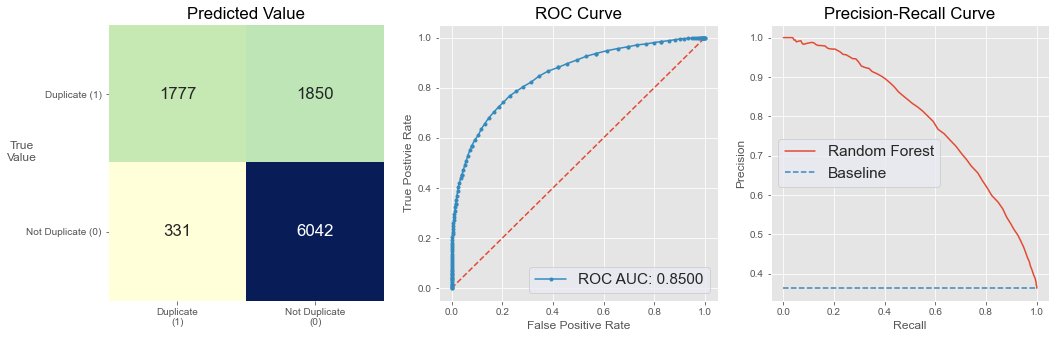

In [14]:
print_metrics(y_test, y_pred, y_prob, 'Random Forest')

## Random Forest
Original, Balanced 

In [21]:
### Create a logistic regression model
clf = RandomForestClassifier(n_estimators=100,
                             n_jobs=16,
                             random_state=42,
                             class_weight='balanced',
                             verbose=1)
### Training the model
clf.fit(X_train, y_train)
### Making predictions on the testing data
y_prob = clf.predict_proba(X_test)
y_pred = np.argmax(y_prob, axis=1)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   10.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   37.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


True Positive: 1712
True Negative: 6100
False Positive (Type 1 error): 1915
False Negative (Type 2 error): 273
Accuracy: 0.7812
Precision: 0.8625
Recall: 0.4720
F1-Score: 0.6101
Log Loss: 0.4907


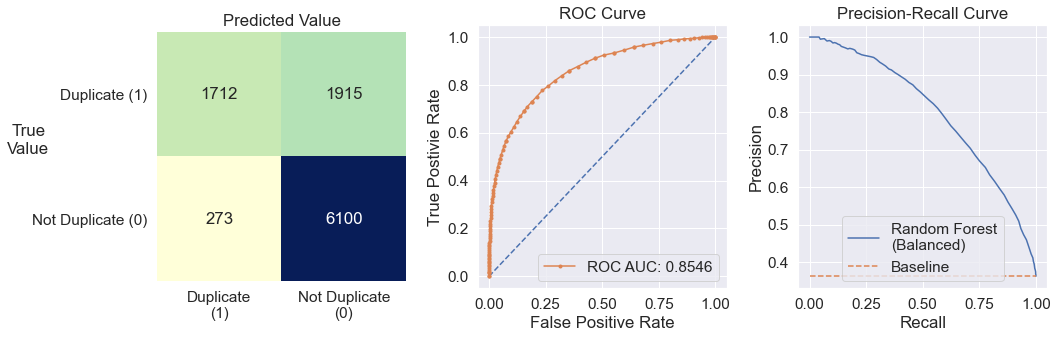

In [22]:
print_metrics(y_test, y_pred, y_prob, 'Random Forest\n(Balanced)')

**Looking at the questions the model incorrectly predicted**

Below I created a function to print out *n* amount of wrong answers from both kinds of errors

In [23]:
def print_wrong_responses(y_test, y_pred, X_test_qs, n=5):
    print("""##############################################################
    Predicted True (y_hat = 1) but actually False (y_test = 0)
    (TYPE 1 ERROR)\n""")
    [print(f"Question 1:{X_test_qs['question1'].loc[example]}\nQuestion 2:{X_test_qs['question2'].loc[example]}", "\n") for example in X_test[(y_test == 0) & (y_pred == 1)].index[:n]]
    
    print("""##############################################################
    Predicted False (y_hat = 0) but actually True (y_test = 1)
    (TYPE 2 ERROR)\n""")
    [print(f"Question 1:{X_test_qs['question1'].loc[example]}\nQuestion 2:{X_test_qs['question2'].loc[example]}", "\n") for example in X_test[(y_test == 1) & (y_pred == 0)].index[:n]]

In [24]:
print_wrong_responses(y_test, y_pred, X_test_qs, n=5)

##############################################################
    Predicted True (y_hat = 1) but actually False (y_test = 0)
    (TYPE 1 ERROR)

Question 1:What are the best books by Indian authors?
Question 2:What are some good Indian novels? 

Question 1:What are some mind-blowing futuristic gadgets that exist that most people don't know about?
Question 2:What are some mind-blowing wallets gadgets that exist that most people don't know about? 

Question 1:How can I feel positive always?
Question 2:How should we feel positive? 

Question 1:What are the most famous novels?
Question 2:What are the most famous novels in each country? 

Question 1:How can I NOT simplify my life?
Question 2:What's the best way to simplify your life? 

##############################################################
    Predicted False (y_hat = 0) but actually True (y_test = 1)
    (TYPE 2 ERROR)

Question 1:How do you determine the value of a 1946 wheat penny?
Question 2:What is the value of a 1946 wheat pe

## Random Forest
Unbalanced, Cleaned Data

In [25]:
### Create a logistic regression model
clf = RandomForestClassifier(n_estimators=100,
                             n_jobs=16,
                             random_state=42,
                             verbose=1)
### Training the model
clf.fit(X_train_cleaned, y_train_cleaned)
### Making predictions on the testing data
y_prob = clf.predict_proba(X_test_cleaned)
y_pred = np.argmax(y_prob, axis=1)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   10.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   40.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


True Positive: 1545
True Negative: 5987
False Positive (Type 1 error): 2082
False Negative (Type 2 error): 386
Accuracy: 0.7532
Precision: 0.8001
Recall: 0.4260
F1-Score: 0.5560
Log Loss: 0.5295


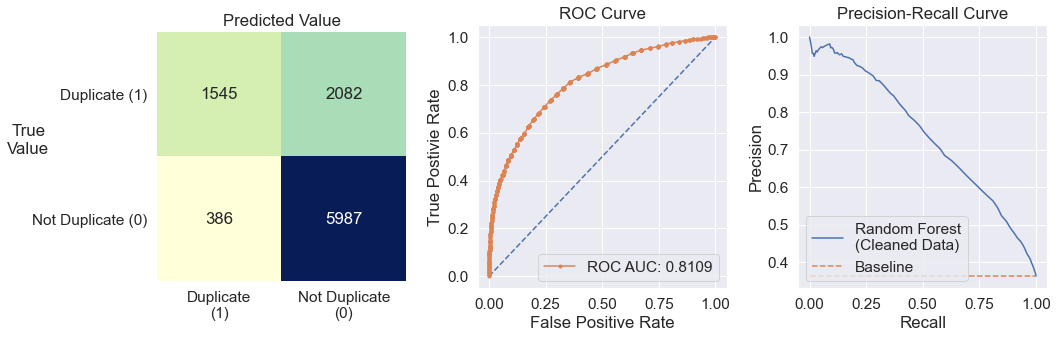

In [26]:
print_metrics(y_test_cleaned, y_pred, y_prob, 'Random Forest\n(Cleaned Data)')

## Random Forest
Balanced, Cleaned data

In [27]:
### Create a logistic regression model
clf = RandomForestClassifier(n_estimators=100,
                             n_jobs=16,
                             random_state=42,
                             class_weight='balanced',
                             verbose=1)
### Training the model
clf.fit(X_train_cleaned, y_train_cleaned)
### Making predictions on the testing data
y_prob = clf.predict_proba(X_test_cleaned)
y_pred = np.argmax(y_prob, axis=1)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   10.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   37.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


True Positive: 1480
True Negative: 6048
False Positive (Type 1 error): 2147
False Negative (Type 2 error): 325
Accuracy: 0.7528
Precision: 0.8199
Recall: 0.4081
F1-Score: 0.5449
Log Loss: 0.5236


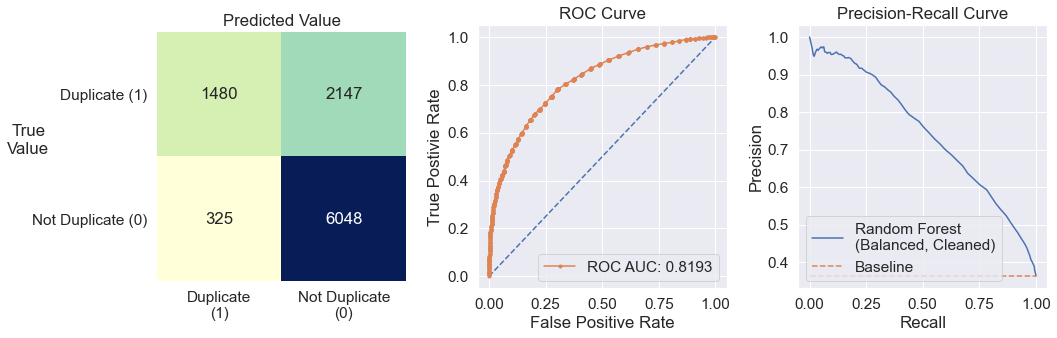

In [28]:
print_metrics(y_test_cleaned, y_pred, y_prob, 'Random Forest\n(Balanced, Cleaned)')

In [29]:
print_wrong_responses(y_test, y_pred, X_test_qs, n=5)

##############################################################
    Predicted True (y_hat = 1) but actually False (y_test = 0)
    (TYPE 1 ERROR)

Question 1:What are the best technology inventions of 2014?
Question 2:What are the best technology inventions? 

Question 1:How can I feel positive always?
Question 2:How should we feel positive? 

Question 1:How can I NOT simplify my life?
Question 2:What's the best way to simplify your life? 

Question 1:How do I raise a fund for a startup IT company?
Question 2:How can I raise funding for my startup? 

Question 1:What were the worst questions asked in Quora?
Question 2:What is the worst question you have found on Quora? 

##############################################################
    Predicted False (y_hat = 0) but actually True (y_test = 1)
    (TYPE 2 ERROR)

Question 1:How do you determine the value of a 1946 wheat penny?
Question 2:What is the value of a 1946 wheat penny? How is this value determined? 

Question 1:What are some co